In [1]:
from importlib import reload
from copy import deepcopy
import os
from torch.utils.data import DataLoader
import torch
import torchvision
from torchvision.transforms import ToTensor, RandomCrop, Compose
from torch import nn, optim
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from PIL import Image
import torchvision.transforms.functional as TF

if not os.path.isdir("./cache"): os.mkdir("cache")
if not os.path.isdir("./data"): os.mkdir("data")

from utils_lib.consts import device, EX2_data_path
print(f'device: {device}')
from utils_lib import utils

device: cuda:2


In [2]:
utils.get_EX2_data()

Downloading...
From: https://drive.google.com/u/0/uc?id=1_36ltHui4gcODBpSxgt-iPgSk7q-E2Gn
To: /specific/netapp5_3/ML_courses/students/DL2020/eladb3/eladb3/dl/dl_ex3/data/EX2_data.zip
176MB [00:05, 31.7MB/s] 


## Net 12

In [3]:
utils.mData12.init()

Prepare 12Net data



Using downloaded and verified file: ./data/VOC/VOCtrainval_11-May-2012.tar
Using downloaded and verified file: ./data/VOC/VOCtrainval_11-May-2012.tar
Finished


>>> Epoch 0, train: loss 0.6857 acc 0.6384, test: loss 0.6744 acc 0.7365, 
>>> Epoch 100, train: loss 0.1617 acc 0.9393, test: loss 0.1678 acc 0.9355, 
>>> Epoch 200, train: loss 0.1201 acc 0.9556, test: loss 0.1343 acc 0.9480, 
>>> Epoch 300, train: loss 0.1001 acc 0.9630, test: loss 0.1206 acc 0.9540, 
Test accuracy has not improved in 11 epochs, stop train
Best model test accuracy: 0.955274760723114, train accuracy: 0.9640147686004639
>>> model saved to ./cache/models.12Net.best_model


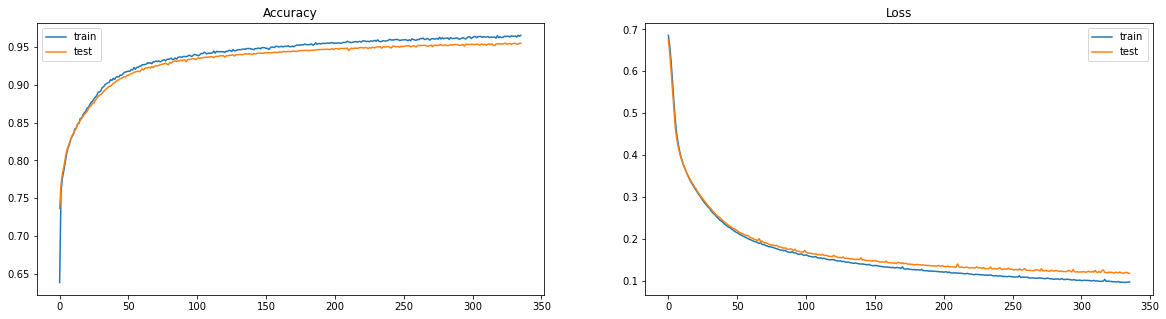

In [4]:
Net12 = nn.Sequential(
    # 3 X 12 X 12
    nn.Conv2d(3, 16, kernel_size = 3, stride = 1, padding = 1),
    # 16 X 12 X 12
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
    # 16 X 6 X 6
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(16 * 6 *6, 16),
    nn.ReLU(),
    nn.Linear(16, 2)
)
utils.train_12Net(Net12, Epochs = 1500, save = True)

### Simple Detector

Modify the 12 Net into FCN:

In [5]:
Net12 = torch.load("cache/models.12Net.best_model")

In [6]:
Net12_layers = list(Net12._modules.values())
#
conv_layer1 = nn.Conv2d(16, 16, kernel_size = 6, stride = 1)
conv_layer1.weight.data = Net12_layers[-3].weight.data.view((16, 16, 6, 6)).detach().clone()
conv_layer1.bias.data = Net12_layers[-3].bias.data.detach().clone()
#
conv_layer2 = nn.Conv2d(16, 2, kernel_size = 1, stride = 1)
conv_layer2.weight.data = Net12_layers[-1].weight.data.view((2, 16, 1, 1)).detach().clone()
conv_layer2.bias.data = Net12_layers[-1].bias.data.detach().clone()

Net12Detector_layers = [deepcopy(l) for l in Net12_layers[:-4]] + [conv_layer1, nn.ReLU(), conv_layer2, nn.Softmax(dim = 1)]
Net12_FCN = nn.Sequential(*Net12Detector_layers)

The detector:

In [7]:
Net12_FCN = Net12_FCN.to(device)
def detector_model(x = None, path = None, iou_threshold = 0.5, scales = [0.05, 0.08, 0.13, 0.2]):
    if x is None:
        x = Image.open(path)
        x = TF.to_tensor(x)
    x = x.to(device)
    if x.size(0) == 1:
        x = torch.cat([x]*3, dim = 0).type(torch.float32).to(device)
    H, W = x.shape[-2:]
    outs = []
    for scale in scales:
        if scale * H < 12 or scale * W < 12: continue # in that case scale is too small
        ret = utils.scale_model_nms_pipeline(x, scale, Net12_FCN, iou_threshold = iou_threshold)
        outs.append(ret.cpu())
    return torch.cat(outs, 0)


After hyper parameters tuning found those scales and iou_threshold to be the optimals

In [8]:
scales = list(map(lambda x: round(x, 2), np.arange(0.05, 0.3, step = 0.02)))
t = 0.5


In [9]:
name =  f"detector_1"
utils.gen_fddb_out(lambda x: detector_model(path = x, iou_threshold = t, scales = scales), ellipse = False, name = name)
cmd = f"{EX2_data_path}/fddb/evaluation/runEvaluate.pl ./fddb-test/{name}/"
print(f">>> {cmd}", end = "")
r = os.system(cmd) 
print(f", result: {r}")

>>> ./data/EX2_data/fddb/evaluation/runEvaluate.pl ./fddb-test/detector_1/, result: 0


Look at some results

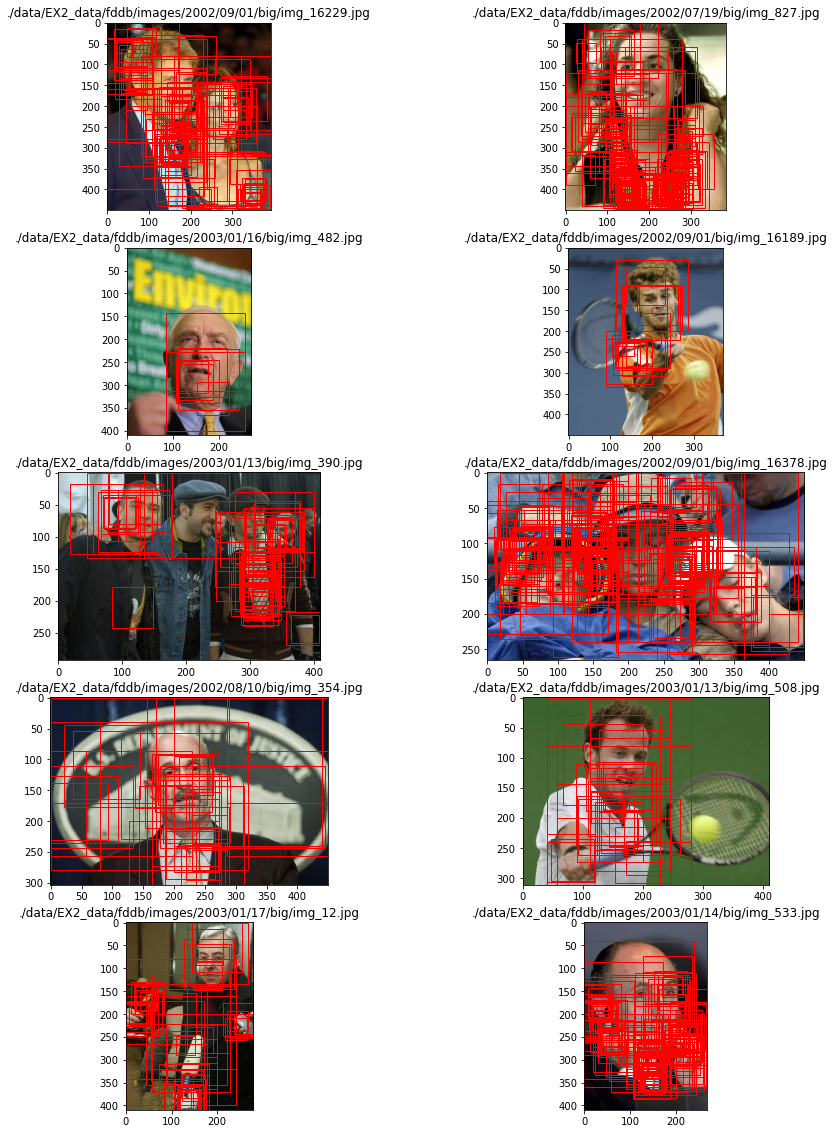

In [10]:
plt.figure(figsize = (15, 20))
for i in range(10):
    plt.subplot(5, 2, i+1)
    path = utils.get_random_fddb_img()
    r= detector_model(path = path, iou_threshold = t, scales = scales)
    x = Image.open(path)
    utils.plot_with_rec(x, r, limit = 0.99)
    plt.title(path)
plt.show()

## 24 Net

Generating the data for the 24 detector using negative mining (code in `utils_lib/data.py`, function `mining`)

In [11]:
x = utils.mData24.init(detector_model, neg_mining = True)

Prepare 24Net data...
>> Start generating noface crops out of 17151 images
Scanned 500 images, generated 722 images
Scanned 1000 images, generated 1546 images
Scanned 1500 images, generated 2754 images
Scanned 2000 images, generated 4064 images
Scanned 2500 images, generated 5433 images
Scanned 3000 images, generated 6895 images
Scanned 3500 images, generated 8324 images
Scanned 4000 images, generated 9653 images
Scanned 4500 images, generated 10987 images
Scanned 5000 images, generated 12435 images
Scanned 5500 images, generated 13625 images
Scanned 6000 images, generated 14573 images
Scanned 6500 images, generated 15275 images
Scanned 7000 images, generated 16318 images
Scanned 7500 images, generated 17653 images
Scanned 8000 images, generated 18933 images
Scanned 8500 images, generated 20339 images
Scanned 9000 images, generated 21812 images
Scanned 9500 images, generated 23181 images
Scanned 10000 images, generated 24544 images
Scanned 10500 images, generated 25924 images
Scanned 1

>>> Epoch 0, train: loss 0.4855 acc 0.7815, test: loss 0.3919 acc 0.8328, 
>>> Epoch 10, train: loss 0.1543 acc 0.9431, test: loss 0.1638 acc 0.9389, 
>>> Epoch 20, train: loss 0.1065 acc 0.9612, test: loss 0.1375 acc 0.9470, 
>>> Epoch 30, train: loss 0.0870 acc 0.9688, test: loss 0.1190 acc 0.9557, 
>>> Epoch 40, train: loss 0.0693 acc 0.9761, test: loss 0.1053 acc 0.9607, 
>>> Epoch 50, train: loss 0.0573 acc 0.9803, test: loss 0.0957 acc 0.9649, 
>>> Epoch 60, train: loss 0.0578 acc 0.9791, test: loss 0.0950 acc 0.9655, 
>>> Epoch 70, train: loss 0.0414 acc 0.9885, test: loss 0.0904 acc 0.9678, 
>>> Epoch 80, train: loss 0.0365 acc 0.9885, test: loss 0.1009 acc 0.9633, 
>>> Epoch 90, train: loss 0.0279 acc 0.9927, test: loss 0.0917 acc 0.9679, 
>>> Epoch 100, train: loss 0.0249 acc 0.9932, test: loss 0.1007 acc 0.9652, 
>>> Epoch 110, train: loss 0.0251 acc 0.9922, test: loss 0.0905 acc 0.9697, 
>>> Epoch 120, train: loss 0.0149 acc 0.9968, test: loss 0.0936 acc 0.9696, 
>>> Epoch 

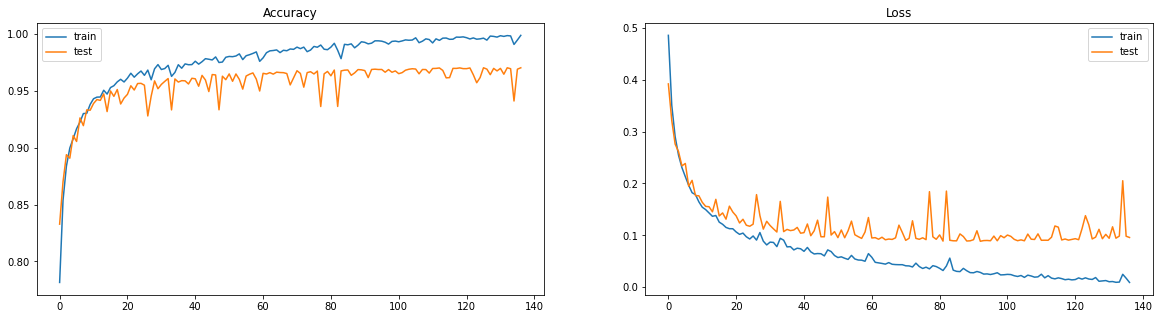

In [12]:
Net24 = nn.Sequential(
    # 3 X 24 X 24
    nn.Conv2d(3, 64, kernel_size = 5, stride = 1, padding = 2),
    # 64 X 24 X 24
    nn.ReLU(),
    nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1),
    # 64 X 12 X 12
    nn.ReLU(),
    nn.Flatten(),
    nn.Linear(64 * 12 * 12, 128),
    nn.ReLU(),
    nn.Linear(128, 2)
)
utils.train_24Net(Net24, Epochs = 1000, save = True, batch_size = 64)

## Better Detector

In [13]:
Net24 = torch.load("cache/models.24Net.best_model")

In [14]:
Net24= Net24.to(device)
def detector_model2(x = None, path = None, iou_threshold = 0.5, scales = [0.05, 0.08, 0.13, 0.2]):
    if x is None:
        x = Image.open(path)
        x = TF.to_tensor(x)
    x = x.to(device)
    if x.size(0) == 1:
        x = torch.cat([x]*3, dim = 0).type(torch.float32).to(device)
    out = utils.scale_model_nms_pipeline(x, scales, Net12_FCN, iou_threshold = iou_threshold).cpu() # (N_crops, 5)
    # use 24Net to reduce FP
    with torch.no_grad():
        out_resized = utils.get_resized_crops(x, out, size = 24).to(device) # (N_crops, 3, 24, 24)
        out24 = Net24(out_resized).cpu() #(N_crops, 2)
    
    net24_threshold = 0.5
    net24_probs = out24[:, 1] # face prob
    out[:, -1] *= net24_probs
    return out
    
        

In [15]:
name =  f"detector_2"
utils.gen_fddb_out(lambda x: detector_model2(path = x, iou_threshold = t, scales = scales), ellipse = False, name = name)
cmd = f"{EX2_data_path}/fddb/evaluation/runEvaluate.pl ./fddb-test/{name}/"
print(f">>> {cmd}", end = "")
r = os.system(cmd) 
print(f", result: {r}")

>>> ./data/EX2_data/fddb/evaluation/runEvaluate.pl ./fddb-test/detector_2/, result: 0


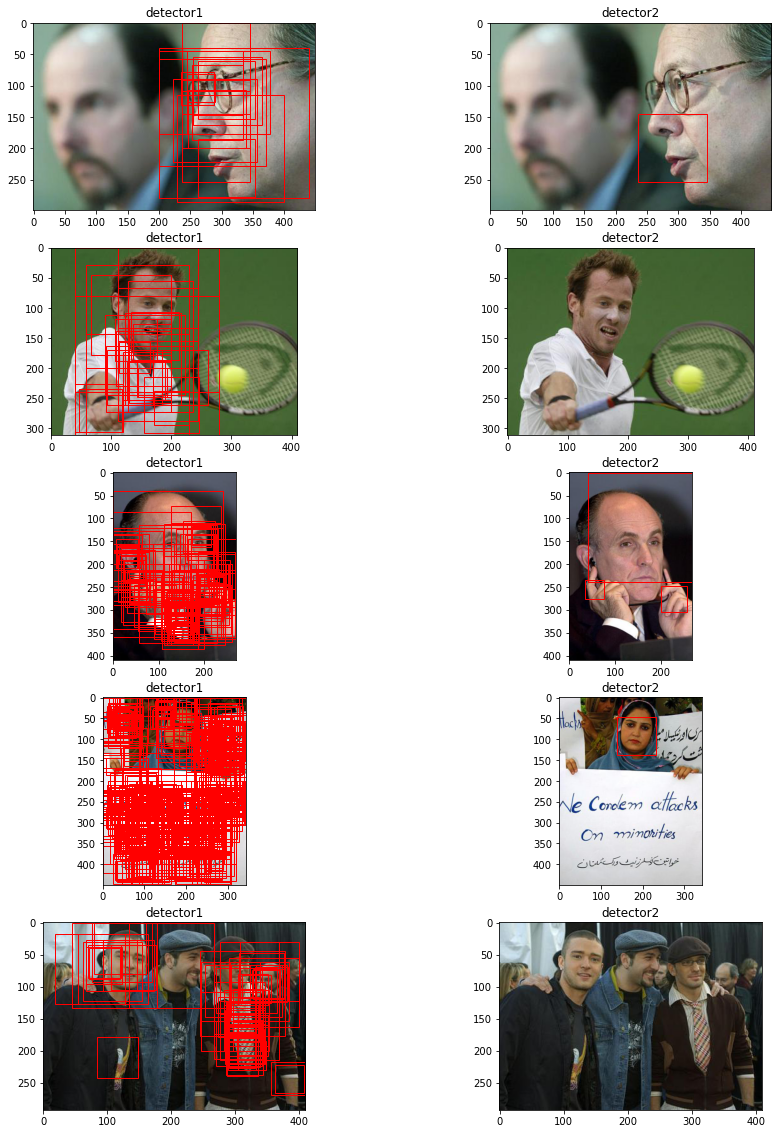

In [18]:
plt.figure(figsize = (15, 20))
for i in range(5):
    path = utils.get_random_fddb_img()
    plt.subplot(5, 2, i*2+1)
    r= detector_model(path = path, iou_threshold = t, scales = scales)
    x = Image.open(path)
    utils.plot_with_rec(x, r, limit = 0.99)
    plt.title(f"detector1")
    plt.subplot(5, 2, i*2+2)
    r= detector_model2(path = path, iou_threshold = t, scales = scales)
    x = Image.open(path)
    utils.plot_with_rec(x, r, limit = 0.99)
    plt.title(f"detector2")

plt.show()

We can see reduction in false positives